In [47]:
import circuitsvis as cv
import transformer_lens
import transformer_lens.utils as utils
import torch
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
import os
from transformer_lens import FactoredMatrix, ActivationCache
from mazelens.nets.modules.hooked_gpt import HookedGPT
from mazelens.nets.modules.hooked_gpt_config import HookedGPTConfig
from mazelens.configs.root import WBLoggerConfig
from mazelens.envs import *
from mazelens.util.util import *
from mazelens.trainers import *
from mazelens.nets.impala import ImpalaPolicyNet
from mazelens.nets.state_encoders.hooked_dt import HookedTransformerStateEncoder
from mazelens.envs.aj3_maze import AJ3MazeEnv
import mazelens.util.util as mutil
from mazelens.util.structs import ExperienceDict
from PIL import Image, ImageOps, ImageFont, ImageDraw
from torch.nn import functional as F
from einops import rearrange
from torch.distributions import Categorical
import hydra
from IPython.display import display, HTML
import IPython

import pathlib
import circuitsvis as cv

import warnings
warnings.filterwarnings("ignore")

torch.set_grad_enabled(False)

In [48]:
# Variables
model_path = '/Users/pranavputta/Downloads/epoch_6000_student.pt'
experiment = '+experiment=aj3/ad/explore/ppo_11x11'

## Utility Functions

In [49]:
action_map = {0: "RIGHT", 1: "LEFT", 2: "DOWN", 3: "UP"}

def grid_to_frame(f, s, v, su, a, max_width=500):
    img = maze_to_rgb(f)
    img_height, img_width = img.shape[:2]
    ratio = max_width // img_width
    img_height, img_width = img_height * ratio, img_width * ratio
    img = Image.fromarray(img).resize((img_height, img_width), resample=Image.NEAREST)

    # Add padding to the image
    font_size = 32
    font = ImageFont.truetype("../misc/arial.ttf", size=font_size)
    padding = 50
    if v and not su:
        padding_color = (0, 0, 0)  # White color, you can change it to your desired color
    elif v and su:
        padding_color = (0, 255, 0)
    else:
        padding_color = (255, 0, 0)
    padded_image = ImageOps.expand(img, border=padding, fill=padding_color)
    draw = ImageDraw.Draw(padded_image)
    text = "Action: {}".format(action_map[a])  # Replace "action" with your desired action text
    text_width, text_height = draw.textsize(text, font=font)
    x = (padded_image.width - text_width) // 2
    y = padded_image.height - padding - text_height * 2

    # Overlay the text on the image
    draw.text((x, y), text, fill=(255, 255, 255), font=font)

    # Overlay the agent view on the image
    if True:
        partial_view_rgb = maze_to_rgb(s)
        partial_view_size = max_width // 6

        partial_height, partial_width = partial_view_rgb.shape[:2]
        ratio = partial_view_size // partial_width
        partial_height, partial_width = ratio * partial_height, ratio * partial_width

        small_map_x = padded_image.width - (partial_width // 2) - padding
        small_map_y = padded_image.height - (partial_height // 2) - padding

        p_img = Image.fromarray(partial_view_rgb).resize((partial_height, partial_width),
                                                         resample=Image.NEAREST)
        # Add a border around the partial view image
        border_color = (255, 255, 255)
        border_thickness = 5
        p_img = ImageOps.expand(p_img, border=border_thickness, fill=border_color)
        padded_image.paste(p_img, (small_map_x, small_map_y))

    return padded_image

In [50]:
def embed(self, inp):
    s, a, r = inp.states, inp.actions, inp.rewards
    assert s is not None, 'states must be provided'
    b, t, p, q = s.shape

    # embed tokens
    s = s.long()
    s = rearrange(s, 'b t x y -> b t (x y)')
    s = self.tok_embd(s)
    s = rearrange(s, 'b t (x y) d -> (b t) d x y', x=p, y=q)
    s = self.impala(s)
    s = rearrange(s, '(b t) d -> b t d', b=b)

    tokens = {'s': s}
    if 'a' in self.condition_on and a is not None:
        tokens['a'] = self.action_embd(a.long())
    if 'r' in self.condition_on and r is not None:
        r = rearrange(r, 'b ... -> b ... 1')
        tokens['r'] = self.reward_embd(r.float())

    if t == 1:
        # in the case of a single step, we need to modify the order of the tokens to match the order of the
        # environment outputs.
        rotated_cond = self.condition_on
        if rotated_cond == 'sa':
            rotated_cond = 'as'
        elif rotated_cond == 'sar':
            rotated_cond = 'ars'
        elif rotated_cond == 'rsa':
            rotated_cond = 'rsa'
        keys, x = zip(*[(k, tokens[k]) for k in rotated_cond if k in tokens])
        x = torch.cat(x, dim=1)
    else:
        keys, x = zip(*[(k, tokens[k]) for k in self.condition_on if k in tokens])
        # interleave tokens into a sequence
        x = torch.stack(x, dim=2).view(b, t * len(x), self.hidden_dim)
    head_position = keys.index('s')
    return x, head_position

## Setup Config and Necessary Components

In [51]:
from hydra import initialize, compose
from omegaconf import OmegaConf

hydra.core.global_hydra.GlobalHydra.instance().clear()

with initialize(version_base=None, config_path="../configs/"):
    cfg = compose(config_name='config.yaml', overrides=[experiment])

pcfg = cfg.trainer.agent.policy
rcfg = pcfg.rnn
ecfg = cfg.trainer.env

### Construct Network from Config

In [6]:
rnn = HookedTransformerStateEncoder(rcfg.n_layers, rcfg.d_model, rcfg.d_head, rcfg.n_heads,
                                    rcfg.d_mlp, rcfg.act_fn, rcfg.n_ctx, rcfg.mode)
policy = ImpalaPolicyNet(pcfg.in_dim, pcfg.embd_vocab_size, pcfg.embd_dim, pcfg.hidden_dim,
               pcfg.scale, pcfg.out_dim, pcfg.condition_on, rnn)
policy = policy.eval()

### Load Model Weights

In [7]:
state_dict = torch.load(model_path, map_location='cpu')
policy.load_state_dict(state_dict['policy'])

<All keys matched successfully>

### Construct Environment

In [8]:
env = AJ3MazeEnv(ecfg.static_env, ecfg.static_episode, ecfg.difficulty, ecfg.reward_type, cfg.seed, ecfg.visible_radius, ecfg.num_objects, ecfg.size, ecfg.max_steps)
state, info = env.reset()

## Start Interpreting!

### Utility Functions

In [52]:
def construct_episode(_policy, _env, deterministic=True, seed=None):
    _policy.eval()
    state, info = _env.reset(episode_seed=seed)
    past_kv_cache = _policy.rnn.initialize_hidden(1)
    exp = ExperienceDict(prev_dones=[True], prev_hiddens=past_kv_cache, states=torch.tensor(state[None, None]), infos=info)
    done = False
    episode = []
    while not done:
        exp.prev_dones = torch.tensor(exp.prev_dones)
        features, action_logits, hx = _policy(exp)
        dist = Categorical(logits=action_logits)
        if deterministic:
            actions = dist.mode
        else:
            actions = dist.sample()
        action = actions.squeeze()

        next_states, rwds, success, truncated, next_infos = _env.step(action)
        exp.actions = action.detach().clone()
        exp.rewards = rwds
        exp.success = success
        done = success or truncated

        episode.append(exp)

        exp = ExperienceDict(prev_dones=[done],
                                 prev_hiddens=hx,
                                 states=torch.tensor(next_states[None, None]),
                                 infos=next_infos,
                                 actions=actions,
                                 rewards=rwds,
                                 truncated=None, success=None)


    return episode
        
def show_episode_video(_episode, save_all=True, filename='tmp'):
    os.makedirs(f"imgs/{filename}/", exist_ok=True)

    animation_filename = f'imgs/{filename}/animation_{filename}.gif'
    
    frames = [grid_to_frame(e.infos['full_view'], e.states.squeeze(), e.infos['valid'], e.success, e.actions.item()) for e in _episode]
    frames[0].save(animation_filename, format="GIF", append_images=frames,
                   save_all=True, duration=1000, loop=0)

    if save_all:
        for i, frame in enumerate(frames):
            frame.save(f"imgs/{filename}/{i}.png")
    return animation_filename

def set_seed_everywhere(seed: int):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

def cat_episode(_episode):
    exp = ExperienceDict(prev_dones=[], states=[], actions=[], rewards=[])
    for frame in _episode:
        exp.prev_dones.append(frame.prev_dones)
        exp.states.append(frame.states)
        exp.actions.append(frame.actions)
        exp.rewards.append(frame.rewards)
    exp.prev_dones = torch.tensor(exp.prev_dones)
    exp.states = torch.cat(exp.states, dim=1)
    exp.actions = torch.tensor(exp.actions)
    exp.rewards = torch.tensor(exp.rewards)
    return exp

### Construct Episode Sequence to Hook

Episode of Length 17. Observations are of shape 5x5


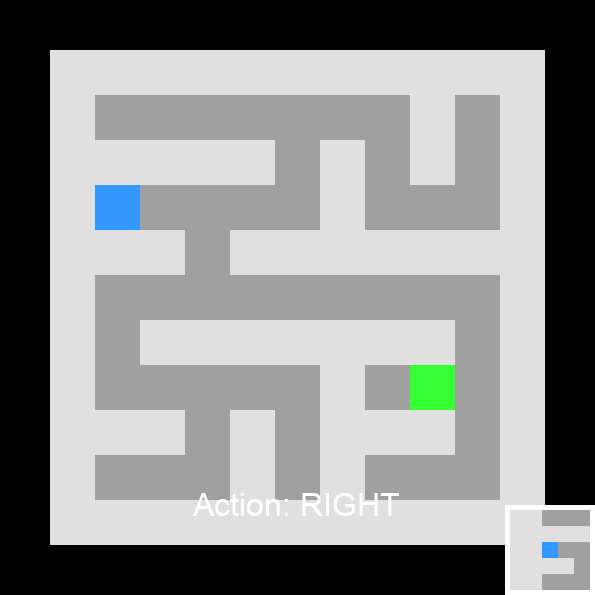

In [54]:
# Construct Episode
seed = 5
set_seed_everywhere(seed)
episode = construct_episode(policy, env, deterministic=True, seed=seed)
shape = episode[0].states.shape
print(f"Episode of Length {len(episode)}. Observations are of shape {shape[2]}x{shape[3]}")
# show as video
gif_filename = show_episode_video(episode, filename=f"{seed}")
display(IPython.display.Image(filename=gif_filename, format='png'))

In [55]:
episode = cat_episode(episode)
x, head_pos = embed(policy, episode)
gpt_logits, gpt_cache = policy.rnn.gpt.run_with_cache(x)

In [56]:
#print((gpt_cache.keys()))
layer = 1
attention_pattern = gpt_cache["pattern", layer, "attn"].squeeze()
actions = [f'{i}-{action_map[a.item()]}' for i, a in enumerate(episode.actions)]
print(f"Layer {layer} Head Attention Patterns:")
cv.attention.attention_patterns(attention=attention_pattern, tokens=actions)

Layer 1 Head Attention Patterns:


In [33]:
act_probs = F.softmax(policy.action_head(gpt_logits.squeeze()), dim=-1)
for i in range(act_probs.shape[0]):
    print(f"{i}: {act_probs[i]}")

0: tensor([0.0149, 0.1223, 0.0122, 0.8505])
1: tensor([0.0072, 0.0723, 0.0212, 0.8993])
2: tensor([0.0184, 0.7083, 0.0441, 0.2292])
3: tensor([0.0662, 0.7094, 0.0375, 0.1869])
4: tensor([0.0398, 0.7282, 0.0321, 0.1999])
5: tensor([0.0296, 0.7602, 0.0299, 0.1803])
6: tensor([0.0193, 0.7656, 0.0242, 0.1910])
7: tensor([0.0321, 0.8795, 0.0371, 0.0514])
8: tensor([0.0246, 0.8546, 0.0407, 0.0801])
